# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*1
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.299163, Accuracy: 12.50
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.363844, Accuracy: 6.64
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.315773, Accuracy: 10.16
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.287831, Accuracy: 14.45
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.342692, Accuracy: 14.06
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.319940, Accuracy: 12.50
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.221014, Accuracy: 16.02
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.307380, Accuracy: 12.11
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.325997, Accuracy: 12.50
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.314395, Accuracy: 14.45
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.398648, Accuracy: 11.33
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.213932, Accuracy: 14.45
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.167650, Accuracy: 14.06
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.194702, Accuracy: 19.53
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.205210, Accuracy: 16.41
Train Epoch

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.488087, Accuracy: 43.75
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.520939, Accuracy: 36.72
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.541944, Accuracy: 40.62
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.590273, Accuracy: 37.89
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.548575, Accuracy: 41.80
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.504360, Accuracy: 39.45
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.508790, Accuracy: 39.45
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.529989, Accuracy: 40.62
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.468130, Accuracy: 43.75
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.485421, Accuracy: 46.88
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.514884, Accuracy: 44.92
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.482904, Accuracy: 46.88
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.367887, Accuracy: 48.05
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.351625, Accuracy: 50.00
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.372648, Accuracy: 5

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.881978, Accuracy: 70.70
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.902986, Accuracy: 69.14
Train Epoch: 6 [29440/50000 (65%)]	Loss: 1.042276, Accuracy: 62.50
Train Epoch: 6 [30720/50000 (68%)]	Loss: 1.001053, Accuracy: 64.06
Train Epoch: 6 [32000/50000 (71%)]	Loss: 1.009541, Accuracy: 64.45
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.961700, Accuracy: 62.50
Train Epoch: 6 [34560/50000 (77%)]	Loss: 1.061793, Accuracy: 65.23
Train Epoch: 6 [35840/50000 (80%)]	Loss: 1.024943, Accuracy: 63.67
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.974980, Accuracy: 62.89
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.867566, Accuracy: 69.14
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.992152, Accuracy: 66.41
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.939165, Accuracy: 67.19
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.907185, Accuracy: 67.58
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.926584, Accuracy: 66.41
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.844185, Accuracy: 6

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.615576, Accuracy: 78.91
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.876861, Accuracy: 68.75
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.725457, Accuracy: 76.17
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.719431, Accuracy: 73.83
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.774504, Accuracy: 70.00

Validation set: Average loss: 0.9951, Accuracy: 3385/5000 (67.00%)

the time of this epoch:[35.7651903629303 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.650134, Accuracy: 78.52
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.689337, Accuracy: 74.22
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.607822, Accuracy: 78.91
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.728098, Accuracy: 74.22
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.538873, Accuracy: 80.47
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.671259, Accuracy: 75.78
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.716126, Accuracy: 72.27
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.725944, Accuracy: 76.17
Train Epoch: 10 [10240/

Train Epoch: 11 [25600/50000 (57%)]	Loss: 0.695758, Accuracy: 75.78
Train Epoch: 11 [26880/50000 (60%)]	Loss: 0.655846, Accuracy: 78.52
Train Epoch: 11 [28160/50000 (62%)]	Loss: 0.681582, Accuracy: 77.73
Train Epoch: 11 [29440/50000 (65%)]	Loss: 0.549185, Accuracy: 80.08
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.644344, Accuracy: 78.12
Train Epoch: 11 [32000/50000 (71%)]	Loss: 0.749969, Accuracy: 78.12
Train Epoch: 11 [33280/50000 (74%)]	Loss: 0.609944, Accuracy: 76.95
Train Epoch: 11 [34560/50000 (77%)]	Loss: 0.690347, Accuracy: 75.00
Train Epoch: 11 [35840/50000 (80%)]	Loss: 0.646117, Accuracy: 77.73
Train Epoch: 11 [37120/50000 (82%)]	Loss: 0.696785, Accuracy: 77.34
Train Epoch: 11 [38400/50000 (85%)]	Loss: 0.580561, Accuracy: 80.86
Train Epoch: 11 [39680/50000 (88%)]	Loss: 0.679817, Accuracy: 77.34
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.618010, Accuracy: 77.73
Train Epoch: 11 [42240/50000 (94%)]	Loss: 0.495297, Accuracy: 85.16
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.7691

Train Epoch: 14 [35840/50000 (80%)]	Loss: 0.504812, Accuracy: 82.81
Train Epoch: 14 [37120/50000 (82%)]	Loss: 0.612828, Accuracy: 78.52
Train Epoch: 14 [38400/50000 (85%)]	Loss: 0.544476, Accuracy: 79.69
Train Epoch: 14 [39680/50000 (88%)]	Loss: 0.605362, Accuracy: 79.30
Train Epoch: 14 [40960/50000 (91%)]	Loss: 0.596490, Accuracy: 79.69
Train Epoch: 14 [42240/50000 (94%)]	Loss: 0.486098, Accuracy: 84.77
Train Epoch: 14 [43520/50000 (97%)]	Loss: 0.505759, Accuracy: 85.94
Train Epoch: 14 [35000/50000 (99%)]	Loss: 0.543526, Accuracy: 83.00

Validation set: Average loss: 0.7035, Accuracy: 3804/5000 (76.00%)

the time of this epoch:[35.77878212928772 s]

Test set: Average loss: 0.6964, Accuracy: 7677/10000 (76.77%)

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.534181, Accuracy: 80.47
Train Epoch: 15 [1280/50000 (3%)]	Loss: 0.525186, Accuracy: 81.64
Train Epoch: 15 [2560/50000 (6%)]	Loss: 0.538213, Accuracy: 82.81
Train Epoch: 15 [3840/50000 (9%)]	Loss: 0.504810, Accuracy: 83.20
Train Epoch: 15 [

Train Epoch: 17 [35000/50000 (99%)]	Loss: 0.622972, Accuracy: 78.50

Validation set: Average loss: 1.4088, Accuracy: 3082/5000 (61.00%)

the time of this epoch:[38.95738887786865 s]
Train Epoch: 18 [0/50000 (0%)]	Loss: 0.375126, Accuracy: 87.50
Train Epoch: 18 [1280/50000 (3%)]	Loss: 0.453524, Accuracy: 86.33
Train Epoch: 18 [2560/50000 (6%)]	Loss: 0.482831, Accuracy: 83.20
Train Epoch: 18 [3840/50000 (9%)]	Loss: 0.357505, Accuracy: 86.72
Train Epoch: 18 [5120/50000 (11%)]	Loss: 0.390622, Accuracy: 88.28
Train Epoch: 18 [6400/50000 (14%)]	Loss: 0.415037, Accuracy: 85.16
Train Epoch: 18 [7680/50000 (17%)]	Loss: 0.437908, Accuracy: 85.94
Train Epoch: 18 [8960/50000 (20%)]	Loss: 0.510512, Accuracy: 81.64
Train Epoch: 18 [10240/50000 (23%)]	Loss: 0.490303, Accuracy: 83.98
Train Epoch: 18 [11520/50000 (26%)]	Loss: 0.483492, Accuracy: 82.03
Train Epoch: 18 [12800/50000 (28%)]	Loss: 0.389920, Accuracy: 87.11
Train Epoch: 18 [14080/50000 (31%)]	Loss: 0.351586, Accuracy: 89.06
Train Epoch: 18 [

Train Epoch: 21 [5120/50000 (11%)]	Loss: 0.410871, Accuracy: 86.72
Train Epoch: 21 [6400/50000 (14%)]	Loss: 0.469544, Accuracy: 85.55
Train Epoch: 21 [7680/50000 (17%)]	Loss: 0.408407, Accuracy: 86.33
Train Epoch: 21 [8960/50000 (20%)]	Loss: 0.596469, Accuracy: 79.30
Train Epoch: 21 [10240/50000 (23%)]	Loss: 0.460763, Accuracy: 85.55
Train Epoch: 21 [11520/50000 (26%)]	Loss: 0.445019, Accuracy: 85.94
Train Epoch: 21 [12800/50000 (28%)]	Loss: 0.548675, Accuracy: 80.47
Train Epoch: 21 [14080/50000 (31%)]	Loss: 0.463139, Accuracy: 85.55
Train Epoch: 21 [15360/50000 (34%)]	Loss: 0.448365, Accuracy: 85.55
Train Epoch: 21 [16640/50000 (37%)]	Loss: 0.452142, Accuracy: 83.98
Train Epoch: 21 [17920/50000 (40%)]	Loss: 0.469326, Accuracy: 83.59
Train Epoch: 21 [19200/50000 (43%)]	Loss: 0.448576, Accuracy: 84.38
Train Epoch: 21 [20480/50000 (45%)]	Loss: 0.347341, Accuracy: 87.89
Train Epoch: 21 [21760/50000 (48%)]	Loss: 0.631081, Accuracy: 77.34
Train Epoch: 21 [23040/50000 (51%)]	Loss: 0.469695, 

Train Epoch: 24 [1280/50000 (3%)]	Loss: 0.354077, Accuracy: 85.94
Train Epoch: 24 [2560/50000 (6%)]	Loss: 0.386844, Accuracy: 87.50
Train Epoch: 24 [3840/50000 (9%)]	Loss: 0.419282, Accuracy: 88.67
Train Epoch: 24 [5120/50000 (11%)]	Loss: 0.408030, Accuracy: 83.98
Train Epoch: 24 [6400/50000 (14%)]	Loss: 0.433054, Accuracy: 83.59
Train Epoch: 24 [7680/50000 (17%)]	Loss: 0.401839, Accuracy: 87.50
Train Epoch: 24 [8960/50000 (20%)]	Loss: 0.385073, Accuracy: 87.89
Train Epoch: 24 [10240/50000 (23%)]	Loss: 0.493798, Accuracy: 83.20
Train Epoch: 24 [11520/50000 (26%)]	Loss: 0.337925, Accuracy: 89.45
Train Epoch: 24 [12800/50000 (28%)]	Loss: 0.326849, Accuracy: 88.67
Train Epoch: 24 [14080/50000 (31%)]	Loss: 0.526659, Accuracy: 82.81
Train Epoch: 24 [15360/50000 (34%)]	Loss: 0.476333, Accuracy: 84.77
Train Epoch: 24 [16640/50000 (37%)]	Loss: 0.436090, Accuracy: 85.16
Train Epoch: 24 [17920/50000 (40%)]	Loss: 0.373259, Accuracy: 88.28
Train Epoch: 24 [19200/50000 (43%)]	Loss: 0.409881, Accura

Train Epoch: 26 [42240/50000 (94%)]	Loss: 0.368155, Accuracy: 87.11
Train Epoch: 26 [43520/50000 (97%)]	Loss: 0.521007, Accuracy: 83.20
Train Epoch: 26 [35000/50000 (99%)]	Loss: 0.442494, Accuracy: 84.50

Validation set: Average loss: 0.7922, Accuracy: 3760/5000 (75.00%)

the time of this epoch:[56.28773379325867 s]

Test set: Average loss: 0.8156, Accuracy: 7483/10000 (74.83%)

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.404266, Accuracy: 88.28
Train Epoch: 27 [1280/50000 (3%)]	Loss: 0.415141, Accuracy: 83.59
Train Epoch: 27 [2560/50000 (6%)]	Loss: 0.378391, Accuracy: 85.94
Train Epoch: 27 [3840/50000 (9%)]	Loss: 0.424956, Accuracy: 85.16
Train Epoch: 27 [5120/50000 (11%)]	Loss: 0.498086, Accuracy: 84.38
Train Epoch: 27 [6400/50000 (14%)]	Loss: 0.446457, Accuracy: 87.11
Train Epoch: 27 [7680/50000 (17%)]	Loss: 0.434871, Accuracy: 84.38
Train Epoch: 27 [8960/50000 (20%)]	Loss: 0.478264, Accuracy: 82.81
Train Epoch: 27 [10240/50000 (23%)]	Loss: 0.432426, Accuracy: 86.72
Train Epoch: 27 [1152

Train Epoch: 30 [2560/50000 (6%)]	Loss: 0.443635, Accuracy: 83.98
Train Epoch: 30 [3840/50000 (9%)]	Loss: 0.400656, Accuracy: 86.33
Train Epoch: 30 [5120/50000 (11%)]	Loss: 0.291923, Accuracy: 89.45
Train Epoch: 30 [6400/50000 (14%)]	Loss: 0.380546, Accuracy: 89.06
Train Epoch: 30 [7680/50000 (17%)]	Loss: 0.371307, Accuracy: 86.72
Train Epoch: 30 [8960/50000 (20%)]	Loss: 0.413622, Accuracy: 84.77
Train Epoch: 30 [10240/50000 (23%)]	Loss: 0.413661, Accuracy: 85.55
Train Epoch: 30 [11520/50000 (26%)]	Loss: 0.378139, Accuracy: 87.11
Train Epoch: 30 [12800/50000 (28%)]	Loss: 0.373910, Accuracy: 89.06
Train Epoch: 30 [14080/50000 (31%)]	Loss: 0.450208, Accuracy: 88.28
Train Epoch: 30 [15360/50000 (34%)]	Loss: 0.459696, Accuracy: 85.94
Train Epoch: 30 [16640/50000 (37%)]	Loss: 0.433406, Accuracy: 83.98
Train Epoch: 30 [17920/50000 (40%)]	Loss: 0.450865, Accuracy: 83.59
torch.Size([512, 1, 1])
tensor([[[-0.2637]],

        [[-1.0521]],

        [[ 1.7126]],

        [[-1.3581]],

        [[-0

Train Epoch: 30 [19200/50000 (43%)]	Loss: 0.375938, Accuracy: 85.16
Train Epoch: 30 [20480/50000 (45%)]	Loss: 0.475424, Accuracy: 83.98
Train Epoch: 30 [21760/50000 (48%)]	Loss: 0.393143, Accuracy: 86.72
Train Epoch: 30 [23040/50000 (51%)]	Loss: 0.486105, Accuracy: 83.98
Train Epoch: 30 [24320/50000 (54%)]	Loss: 0.445772, Accuracy: 84.77
Train Epoch: 30 [25600/50000 (57%)]	Loss: 0.505426, Accuracy: 83.20
Train Epoch: 30 [26880/50000 (60%)]	Loss: 0.428027, Accuracy: 85.16
Train Epoch: 30 [28160/50000 (62%)]	Loss: 0.437345, Accuracy: 85.16
Train Epoch: 30 [29440/50000 (65%)]	Loss: 0.469872, Accuracy: 85.94
Train Epoch: 30 [30720/50000 (68%)]	Loss: 0.498191, Accuracy: 84.38
Train Epoch: 30 [32000/50000 (71%)]	Loss: 0.464648, Accuracy: 83.98
Train Epoch: 30 [33280/50000 (74%)]	Loss: 0.415944, Accuracy: 85.55
Train Epoch: 30 [34560/50000 (77%)]	Loss: 0.574182, Accuracy: 80.47
Train Epoch: 30 [35840/50000 (80%)]	Loss: 0.380671, Accuracy: 86.33
Train Epoch: 30 [37120/50000 (82%)]	Loss: 0.4713

Train Epoch: 33 [28160/50000 (62%)]	Loss: 0.408817, Accuracy: 85.16
Train Epoch: 33 [29440/50000 (65%)]	Loss: 0.413735, Accuracy: 87.11
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.460827, Accuracy: 84.77
Train Epoch: 33 [32000/50000 (71%)]	Loss: 0.398195, Accuracy: 86.72
Train Epoch: 33 [33280/50000 (74%)]	Loss: 0.434101, Accuracy: 85.16
Train Epoch: 33 [34560/50000 (77%)]	Loss: 0.477589, Accuracy: 86.33
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.469023, Accuracy: 82.42
Train Epoch: 33 [37120/50000 (82%)]	Loss: 0.415314, Accuracy: 87.11
Train Epoch: 33 [38400/50000 (85%)]	Loss: 0.430085, Accuracy: 83.59
Train Epoch: 33 [39680/50000 (88%)]	Loss: 0.443043, Accuracy: 83.98
Train Epoch: 33 [40960/50000 (91%)]	Loss: 0.380273, Accuracy: 88.67
Train Epoch: 33 [42240/50000 (94%)]	Loss: 0.381997, Accuracy: 87.50
Train Epoch: 33 [43520/50000 (97%)]	Loss: 0.444596, Accuracy: 83.20
Train Epoch: 33 [35000/50000 (99%)]	Loss: 0.423944, Accuracy: 82.50

Validation set: Average loss: 0.5620, Accuracy:

Train Epoch: 36 [38400/50000 (85%)]	Loss: 0.502521, Accuracy: 82.42
Train Epoch: 36 [39680/50000 (88%)]	Loss: 0.482863, Accuracy: 83.20
Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.403085, Accuracy: 84.77
Train Epoch: 36 [42240/50000 (94%)]	Loss: 0.352573, Accuracy: 89.06
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.460203, Accuracy: 83.59
Train Epoch: 36 [35000/50000 (99%)]	Loss: 0.501518, Accuracy: 83.50

Validation set: Average loss: 0.6718, Accuracy: 3930/5000 (78.00%)

the time of this epoch:[35.62637734413147 s]

Test set: Average loss: 0.7016, Accuracy: 7777/10000 (77.77%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.332488, Accuracy: 88.67
Train Epoch: 37 [1280/50000 (3%)]	Loss: 0.367603, Accuracy: 87.89
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.472229, Accuracy: 85.16
Train Epoch: 37 [3840/50000 (9%)]	Loss: 0.346960, Accuracy: 87.89
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.341343, Accuracy: 87.50
Train Epoch: 37 [6400/50000 (14%)]	Loss: 0.340633, Accuracy: 89.06
Train Epoch: 37 [76

Train Epoch: 40 [1280/50000 (3%)]	Loss: 0.383493, Accuracy: 87.89
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.341826, Accuracy: 89.84
Train Epoch: 40 [3840/50000 (9%)]	Loss: 0.318757, Accuracy: 87.89
Train Epoch: 40 [5120/50000 (11%)]	Loss: 0.400480, Accuracy: 84.38
Train Epoch: 40 [6400/50000 (14%)]	Loss: 0.319145, Accuracy: 87.11
Train Epoch: 40 [7680/50000 (17%)]	Loss: 0.392847, Accuracy: 87.89
Train Epoch: 40 [8960/50000 (20%)]	Loss: 0.378811, Accuracy: 88.28
Train Epoch: 40 [10240/50000 (23%)]	Loss: 0.263613, Accuracy: 91.41
Train Epoch: 40 [11520/50000 (26%)]	Loss: 0.428231, Accuracy: 85.94
Train Epoch: 40 [12800/50000 (28%)]	Loss: 0.454602, Accuracy: 84.38
Train Epoch: 40 [14080/50000 (31%)]	Loss: 0.332892, Accuracy: 88.28
torch.Size([512, 1, 1])
tensor([[[ 1.0442e+00]],

        [[-2.5395e-02]],

        [[-8.1968e-01]],

        [[ 5.5749e-01]],

        [[-2.3843e-01]],

        [[-1.8767e+00]],

        [[ 8.4855e-01]],

        [[ 1.1047e+00]],

        [[-1.8991e+00]],

    

Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.373904, Accuracy: 87.11
Train Epoch: 40 [16640/50000 (37%)]	Loss: 0.354775, Accuracy: 87.89
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.442323, Accuracy: 85.16
Train Epoch: 40 [19200/50000 (43%)]	Loss: 0.397162, Accuracy: 87.50
Train Epoch: 40 [20480/50000 (45%)]	Loss: 0.427829, Accuracy: 84.38
Train Epoch: 40 [21760/50000 (48%)]	Loss: 0.363176, Accuracy: 87.50
Train Epoch: 40 [23040/50000 (51%)]	Loss: 0.432199, Accuracy: 86.33
Train Epoch: 40 [24320/50000 (54%)]	Loss: 0.293947, Accuracy: 89.45
Train Epoch: 40 [25600/50000 (57%)]	Loss: 0.510069, Accuracy: 84.77
Train Epoch: 40 [26880/50000 (60%)]	Loss: 0.370854, Accuracy: 85.16
Train Epoch: 40 [28160/50000 (62%)]	Loss: 0.413671, Accuracy: 83.59
Train Epoch: 40 [29440/50000 (65%)]	Loss: 0.335925, Accuracy: 87.89
Train Epoch: 40 [30720/50000 (68%)]	Loss: 0.419799, Accuracy: 85.16
Train Epoch: 40 [32000/50000 (71%)]	Loss: 0.470080, Accuracy: 84.38
Train Epoch: 40 [33280/50000 (74%)]	Loss: 0.3177

Train Epoch: 43 [24320/50000 (54%)]	Loss: 0.404215, Accuracy: 84.77
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.354135, Accuracy: 88.67
Train Epoch: 43 [26880/50000 (60%)]	Loss: 0.320700, Accuracy: 91.02
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.464369, Accuracy: 85.16
Train Epoch: 43 [29440/50000 (65%)]	Loss: 0.334197, Accuracy: 89.84
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.339557, Accuracy: 87.89
Train Epoch: 43 [32000/50000 (71%)]	Loss: 0.390028, Accuracy: 85.55
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.453454, Accuracy: 82.42
Train Epoch: 43 [34560/50000 (77%)]	Loss: 0.379033, Accuracy: 86.72
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.397941, Accuracy: 85.55
Train Epoch: 43 [37120/50000 (82%)]	Loss: 0.390893, Accuracy: 85.94
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.429131, Accuracy: 85.94
Train Epoch: 43 [39680/50000 (88%)]	Loss: 0.435324, Accuracy: 88.28
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.468446, Accuracy: 83.20
Train Epoch: 43 [42240/50000 (94%)]	Loss: 0.3543

Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.481552, Accuracy: 83.98
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.336904, Accuracy: 88.28
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.348295, Accuracy: 89.06
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.357603, Accuracy: 88.67
Train Epoch: 46 [14080/50000 (31%)]	Loss: 0.428096, Accuracy: 84.38
Train Epoch: 46 [15360/50000 (34%)]	Loss: 0.358454, Accuracy: 87.89
Train Epoch: 46 [16640/50000 (37%)]	Loss: 0.351588, Accuracy: 88.67
Train Epoch: 46 [17920/50000 (40%)]	Loss: 0.337333, Accuracy: 89.45
Train Epoch: 46 [19200/50000 (43%)]	Loss: 0.380088, Accuracy: 86.72
Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.353480, Accuracy: 85.94
Train Epoch: 46 [21760/50000 (48%)]	Loss: 0.314172, Accuracy: 91.80
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.426722, Accuracy: 87.89
Train Epoch: 46 [24320/50000 (54%)]	Loss: 0.381057, Accuracy: 87.50
Train Epoch: 46 [25600/50000 (57%)]	Loss: 0.416866, Accuracy: 88.67
Train Epoch: 46 [26880/50000 (60%)]	Loss: 0.36367

Train Epoch: 48 [0/50000 (0%)]	Loss: 0.401424, Accuracy: 85.16
Train Epoch: 48 [1280/50000 (3%)]	Loss: 0.415324, Accuracy: 85.55
Train Epoch: 48 [2560/50000 (6%)]	Loss: 0.387319, Accuracy: 89.84
Train Epoch: 48 [3840/50000 (9%)]	Loss: 0.317635, Accuracy: 91.80
Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.445667, Accuracy: 84.38
Train Epoch: 48 [6400/50000 (14%)]	Loss: 0.376507, Accuracy: 87.50
Train Epoch: 48 [7680/50000 (17%)]	Loss: 0.273356, Accuracy: 91.41
Train Epoch: 48 [8960/50000 (20%)]	Loss: 0.296273, Accuracy: 91.41
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.308455, Accuracy: 91.41
Train Epoch: 48 [11520/50000 (26%)]	Loss: 0.291696, Accuracy: 91.41
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.501413, Accuracy: 83.98
Train Epoch: 48 [14080/50000 (31%)]	Loss: 0.441590, Accuracy: 84.38
Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.433535, Accuracy: 85.55
Train Epoch: 48 [16640/50000 (37%)]	Loss: 0.443602, Accuracy: 86.33
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.353536, Accuracy: 8

Train Epoch: 51 [8960/50000 (20%)]	Loss: 0.224357, Accuracy: 91.80
Train Epoch: 51 [10240/50000 (23%)]	Loss: 0.242469, Accuracy: 92.97
Train Epoch: 51 [11520/50000 (26%)]	Loss: 0.236150, Accuracy: 90.23
Train Epoch: 51 [12800/50000 (28%)]	Loss: 0.248336, Accuracy: 92.19
Train Epoch: 51 [14080/50000 (31%)]	Loss: 0.229930, Accuracy: 93.36
Train Epoch: 51 [15360/50000 (34%)]	Loss: 0.270544, Accuracy: 89.06
Train Epoch: 51 [16640/50000 (37%)]	Loss: 0.233126, Accuracy: 93.36
Train Epoch: 51 [17920/50000 (40%)]	Loss: 0.296939, Accuracy: 90.23
Train Epoch: 51 [19200/50000 (43%)]	Loss: 0.240736, Accuracy: 92.19
Train Epoch: 51 [20480/50000 (45%)]	Loss: 0.243844, Accuracy: 92.19
Train Epoch: 51 [21760/50000 (48%)]	Loss: 0.244759, Accuracy: 91.80
Train Epoch: 51 [23040/50000 (51%)]	Loss: 0.184592, Accuracy: 93.36
Train Epoch: 51 [24320/50000 (54%)]	Loss: 0.177756, Accuracy: 94.14
Train Epoch: 51 [25600/50000 (57%)]	Loss: 0.299721, Accuracy: 89.06
Train Epoch: 51 [26880/50000 (60%)]	Loss: 0.20171

Train Epoch: 54 [19200/50000 (43%)]	Loss: 0.131976, Accuracy: 95.70
Train Epoch: 54 [20480/50000 (45%)]	Loss: 0.221398, Accuracy: 92.19
Train Epoch: 54 [21760/50000 (48%)]	Loss: 0.162728, Accuracy: 95.70
Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.200011, Accuracy: 93.36
Train Epoch: 54 [24320/50000 (54%)]	Loss: 0.159967, Accuracy: 93.36
Train Epoch: 54 [25600/50000 (57%)]	Loss: 0.145253, Accuracy: 94.53
Train Epoch: 54 [26880/50000 (60%)]	Loss: 0.134353, Accuracy: 95.31
Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.159640, Accuracy: 95.31
Train Epoch: 54 [29440/50000 (65%)]	Loss: 0.138484, Accuracy: 96.09
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.204034, Accuracy: 92.19
Train Epoch: 54 [32000/50000 (71%)]	Loss: 0.183372, Accuracy: 93.75
Train Epoch: 54 [33280/50000 (74%)]	Loss: 0.102325, Accuracy: 96.48
Train Epoch: 54 [34560/50000 (77%)]	Loss: 0.239256, Accuracy: 92.58
Train Epoch: 54 [35840/50000 (80%)]	Loss: 0.124541, Accuracy: 96.09
Train Epoch: 54 [37120/50000 (82%)]	Loss: 0.1575

Train Epoch: 57 [28160/50000 (62%)]	Loss: 0.131040, Accuracy: 95.70
Train Epoch: 57 [29440/50000 (65%)]	Loss: 0.094729, Accuracy: 97.27
Train Epoch: 57 [30720/50000 (68%)]	Loss: 0.160099, Accuracy: 94.53
Train Epoch: 57 [32000/50000 (71%)]	Loss: 0.154684, Accuracy: 94.92
Train Epoch: 57 [33280/50000 (74%)]	Loss: 0.101756, Accuracy: 97.27
Train Epoch: 57 [34560/50000 (77%)]	Loss: 0.143079, Accuracy: 94.53
Train Epoch: 57 [35840/50000 (80%)]	Loss: 0.166293, Accuracy: 93.75
Train Epoch: 57 [37120/50000 (82%)]	Loss: 0.210754, Accuracy: 92.58
Train Epoch: 57 [38400/50000 (85%)]	Loss: 0.123883, Accuracy: 95.70
Train Epoch: 57 [39680/50000 (88%)]	Loss: 0.114431, Accuracy: 96.48
Train Epoch: 57 [40960/50000 (91%)]	Loss: 0.133648, Accuracy: 96.48
Train Epoch: 57 [42240/50000 (94%)]	Loss: 0.133741, Accuracy: 93.36
Train Epoch: 57 [43520/50000 (97%)]	Loss: 0.194914, Accuracy: 92.97
Train Epoch: 57 [35000/50000 (99%)]	Loss: 0.172517, Accuracy: 92.50

Validation set: Average loss: 0.2801, Accuracy:

Train Epoch: 58 [7680/50000 (17%)]	Loss: 0.083892, Accuracy: 97.66
Train Epoch: 58 [8960/50000 (20%)]	Loss: 0.125161, Accuracy: 94.92
Train Epoch: 58 [10240/50000 (23%)]	Loss: 0.145515, Accuracy: 95.31
Train Epoch: 58 [11520/50000 (26%)]	Loss: 0.066238, Accuracy: 98.44
Train Epoch: 58 [12800/50000 (28%)]	Loss: 0.131774, Accuracy: 96.09
Train Epoch: 58 [14080/50000 (31%)]	Loss: 0.164351, Accuracy: 94.14
Train Epoch: 58 [15360/50000 (34%)]	Loss: 0.155366, Accuracy: 93.36
Train Epoch: 58 [16640/50000 (37%)]	Loss: 0.082641, Accuracy: 97.66
Train Epoch: 58 [17920/50000 (40%)]	Loss: 0.126772, Accuracy: 96.09
Train Epoch: 58 [19200/50000 (43%)]	Loss: 0.098789, Accuracy: 96.48
Train Epoch: 58 [20480/50000 (45%)]	Loss: 0.123690, Accuracy: 94.92
Train Epoch: 58 [21760/50000 (48%)]	Loss: 0.126388, Accuracy: 95.31
Train Epoch: 58 [23040/50000 (51%)]	Loss: 0.090970, Accuracy: 98.44
Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.079768, Accuracy: 97.27
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.191976

Train Epoch: 61 [16640/50000 (37%)]	Loss: 0.105590, Accuracy: 97.27
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.115591, Accuracy: 95.70
Train Epoch: 61 [19200/50000 (43%)]	Loss: 0.106499, Accuracy: 96.48
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.116617, Accuracy: 96.48
Train Epoch: 61 [21760/50000 (48%)]	Loss: 0.140500, Accuracy: 94.53
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.104822, Accuracy: 96.09
Train Epoch: 61 [24320/50000 (54%)]	Loss: 0.123377, Accuracy: 96.88
Train Epoch: 61 [25600/50000 (57%)]	Loss: 0.115155, Accuracy: 96.09
Train Epoch: 61 [26880/50000 (60%)]	Loss: 0.090788, Accuracy: 97.27
Train Epoch: 61 [28160/50000 (62%)]	Loss: 0.075784, Accuracy: 98.05
Train Epoch: 61 [29440/50000 (65%)]	Loss: 0.095356, Accuracy: 97.27
Train Epoch: 61 [30720/50000 (68%)]	Loss: 0.087719, Accuracy: 96.48
Train Epoch: 61 [32000/50000 (71%)]	Loss: 0.090192, Accuracy: 96.48
Train Epoch: 61 [33280/50000 (74%)]	Loss: 0.079034, Accuracy: 96.48
Train Epoch: 61 [34560/50000 (77%)]	Loss: 0.1489

Train Epoch: 64 [26880/50000 (60%)]	Loss: 0.077980, Accuracy: 97.27
Train Epoch: 64 [28160/50000 (62%)]	Loss: 0.084627, Accuracy: 96.88
Train Epoch: 64 [29440/50000 (65%)]	Loss: 0.092792, Accuracy: 98.44
Train Epoch: 64 [30720/50000 (68%)]	Loss: 0.061855, Accuracy: 98.05
Train Epoch: 64 [32000/50000 (71%)]	Loss: 0.084916, Accuracy: 95.70
Train Epoch: 64 [33280/50000 (74%)]	Loss: 0.093857, Accuracy: 97.27
Train Epoch: 64 [34560/50000 (77%)]	Loss: 0.150682, Accuracy: 94.92
Train Epoch: 64 [35840/50000 (80%)]	Loss: 0.117848, Accuracy: 95.70
Train Epoch: 64 [37120/50000 (82%)]	Loss: 0.159816, Accuracy: 94.14
Train Epoch: 64 [38400/50000 (85%)]	Loss: 0.061521, Accuracy: 97.27
Train Epoch: 64 [39680/50000 (88%)]	Loss: 0.054463, Accuracy: 97.66
Train Epoch: 64 [40960/50000 (91%)]	Loss: 0.130532, Accuracy: 94.53
Train Epoch: 64 [42240/50000 (94%)]	Loss: 0.129586, Accuracy: 96.09
Train Epoch: 64 [43520/50000 (97%)]	Loss: 0.128632, Accuracy: 95.31
Train Epoch: 64 [35000/50000 (99%)]	Loss: 0.0870

Train Epoch: 67 [35840/50000 (80%)]	Loss: 0.152347, Accuracy: 94.92
Train Epoch: 67 [37120/50000 (82%)]	Loss: 0.077959, Accuracy: 96.88
Train Epoch: 67 [38400/50000 (85%)]	Loss: 0.054895, Accuracy: 97.66
Train Epoch: 67 [39680/50000 (88%)]	Loss: 0.086125, Accuracy: 96.48
Train Epoch: 67 [40960/50000 (91%)]	Loss: 0.059907, Accuracy: 98.05
Train Epoch: 67 [42240/50000 (94%)]	Loss: 0.127473, Accuracy: 95.31
Train Epoch: 67 [43520/50000 (97%)]	Loss: 0.098831, Accuracy: 97.27
Train Epoch: 67 [35000/50000 (99%)]	Loss: 0.095793, Accuracy: 96.50

Validation set: Average loss: 0.3062, Accuracy: 4534/5000 (90.00%)

the time of this epoch:[38.536805152893066 s]
Train Epoch: 68 [0/50000 (0%)]	Loss: 0.045004, Accuracy: 98.83
Train Epoch: 68 [1280/50000 (3%)]	Loss: 0.071644, Accuracy: 97.66
Train Epoch: 68 [2560/50000 (6%)]	Loss: 0.108619, Accuracy: 97.27
Train Epoch: 68 [3840/50000 (9%)]	Loss: 0.064414, Accuracy: 98.05
Train Epoch: 68 [5120/50000 (11%)]	Loss: 0.052400, Accuracy: 97.66
Train Epoch: 


Validation set: Average loss: 0.3493, Accuracy: 4530/5000 (90.00%)

the time of this epoch:[35.45314645767212 s]

Test set: Average loss: 0.3503, Accuracy: 9029/10000 (90.29%)

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.063958, Accuracy: 97.66
Train Epoch: 71 [1280/50000 (3%)]	Loss: 0.102680, Accuracy: 96.48
Train Epoch: 71 [2560/50000 (6%)]	Loss: 0.062120, Accuracy: 97.66
Train Epoch: 71 [3840/50000 (9%)]	Loss: 0.081578, Accuracy: 96.48
Train Epoch: 71 [5120/50000 (11%)]	Loss: 0.087423, Accuracy: 97.66
Train Epoch: 71 [6400/50000 (14%)]	Loss: 0.082355, Accuracy: 97.27
Train Epoch: 71 [7680/50000 (17%)]	Loss: 0.075287, Accuracy: 96.48
Train Epoch: 71 [8960/50000 (20%)]	Loss: 0.055454, Accuracy: 97.66
Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.068696, Accuracy: 97.66
Train Epoch: 71 [11520/50000 (26%)]	Loss: 0.069526, Accuracy: 98.44
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.063967, Accuracy: 98.05
Train Epoch: 71 [14080/50000 (31%)]	Loss: 0.058727, Accuracy: 98.83
Train Epoch: 71 [1536


Validation set: Average loss: 0.2939, Accuracy: 4579/5000 (91.00%)

the time of this epoch:[35.44555330276489 s]

Test set: Average loss: 0.3072, Accuracy: 9139/10000 (91.39%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.032727, Accuracy: 99.22
Train Epoch: 73 [1280/50000 (3%)]	Loss: 0.044157, Accuracy: 98.44
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.045993, Accuracy: 98.83
Train Epoch: 73 [3840/50000 (9%)]	Loss: 0.028941, Accuracy: 98.44
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.090502, Accuracy: 95.70
Train Epoch: 73 [6400/50000 (14%)]	Loss: 0.054153, Accuracy: 97.66
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.035367, Accuracy: 99.22
Train Epoch: 73 [8960/50000 (20%)]	Loss: 0.061317, Accuracy: 98.05
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.052941, Accuracy: 98.44
Train Epoch: 73 [11520/50000 (26%)]	Loss: 0.043059, Accuracy: 98.83
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.042233, Accuracy: 98.83
Train Epoch: 73 [14080/50000 (31%)]	Loss: 0.060299, Accuracy: 98.05
Train Epoch: 73 [1536

Train Epoch: 76 [6400/50000 (14%)]	Loss: 0.078031, Accuracy: 97.27
Train Epoch: 76 [7680/50000 (17%)]	Loss: 0.035191, Accuracy: 99.22
Train Epoch: 76 [8960/50000 (20%)]	Loss: 0.040510, Accuracy: 99.22
Train Epoch: 76 [10240/50000 (23%)]	Loss: 0.027895, Accuracy: 99.61
Train Epoch: 76 [11520/50000 (26%)]	Loss: 0.068688, Accuracy: 97.66
Train Epoch: 76 [12800/50000 (28%)]	Loss: 0.042177, Accuracy: 98.44
Train Epoch: 76 [14080/50000 (31%)]	Loss: 0.053524, Accuracy: 97.66
Train Epoch: 76 [15360/50000 (34%)]	Loss: 0.079444, Accuracy: 96.48
Train Epoch: 76 [16640/50000 (37%)]	Loss: 0.047946, Accuracy: 98.44
Train Epoch: 76 [17920/50000 (40%)]	Loss: 0.086911, Accuracy: 96.88
Train Epoch: 76 [19200/50000 (43%)]	Loss: 0.052065, Accuracy: 98.44
Train Epoch: 76 [20480/50000 (45%)]	Loss: 0.042702, Accuracy: 98.44
Train Epoch: 76 [21760/50000 (48%)]	Loss: 0.022516, Accuracy: 99.22
Train Epoch: 76 [23040/50000 (51%)]	Loss: 0.022023, Accuracy: 99.22
Train Epoch: 76 [24320/50000 (54%)]	Loss: 0.040394,

Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.031476, Accuracy: 99.22
Train Epoch: 79 [16640/50000 (37%)]	Loss: 0.045120, Accuracy: 98.83
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.052362, Accuracy: 97.66
Train Epoch: 79 [19200/50000 (43%)]	Loss: 0.019260, Accuracy: 99.61
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.026355, Accuracy: 99.61
Train Epoch: 79 [21760/50000 (48%)]	Loss: 0.050151, Accuracy: 98.83
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.035882, Accuracy: 98.83
Train Epoch: 79 [24320/50000 (54%)]	Loss: 0.025629, Accuracy: 99.22
Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.038325, Accuracy: 98.05
Train Epoch: 79 [26880/50000 (60%)]	Loss: 0.035156, Accuracy: 98.83
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.118523, Accuracy: 95.70
Train Epoch: 79 [29440/50000 (65%)]	Loss: 0.037910, Accuracy: 98.83
Train Epoch: 79 [30720/50000 (68%)]	Loss: 0.048825, Accuracy: 99.22
Train Epoch: 79 [32000/50000 (71%)]	Loss: 0.048501, Accuracy: 98.05
Train Epoch: 79 [33280/50000 (74%)]	Loss: 0.0544

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

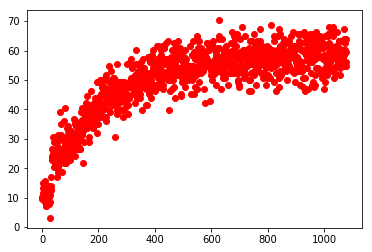

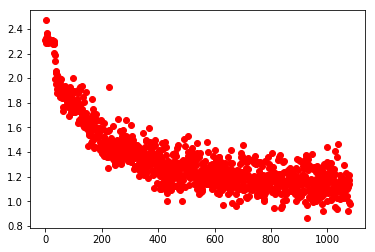

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

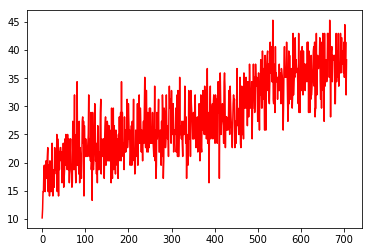

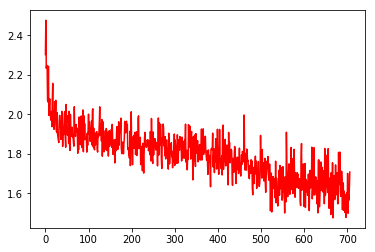

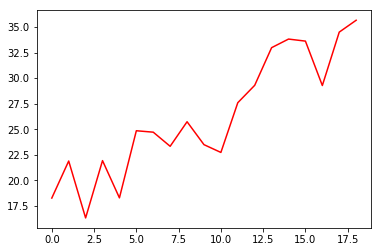

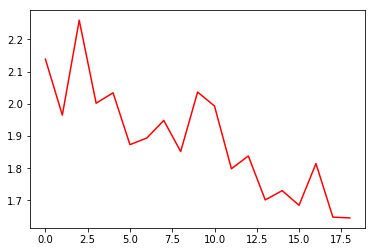

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()